<a href="https://colab.research.google.com/github/l0rdyolo/tomato-leaf-disease/blob/main/tomato_leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



In [ ]:
!pip install kaggle

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
##drive.flush_and_unmount();

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive')


In [ ]:
train_path = "/content/drive/MyDrive/tomato/train"
test_path = "/content/drive/MyDrive/tomato/test"

In [ ]:
from google.colab import files

# Kaggle API anahtarlarınızı yükleyin
uploaded = files.upload()

# Kaggle API anahtarlarını /root/.kaggle/ dizinine taşıyın
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list

ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                         Online Food Dataset                              3KB  2024-03-02 18:50:30          18470        370  0.9411765        
jatinthakur706/most-watched-netflix-original-shows-tv-time  Most watched Netflix original shows (TV Time)    2KB  2024-03-27 09:01:21           1554         25  1.0              
mexwell/drug-consumption-classification                     💊 Drug Consumption Classification               56KB  2024-03-28 15:02:22           1332         26  1.0              
samira1992/diabetes-intermediate-dataset                    🩸 Diabetes - Intermediate 🗃️ Dataset         

In [ ]:
!kaggle datasets download -d noulam/tomato

 99% 737M/743M [00:16<00:00, 27.7MB/s]
100% 743M/743M [00:16<00:00, 46.4MB/s]


In [ ]:
!unzip tomato.zip

In [ ]:
!ls

'2024 Bahar'	    kaggle				    'New Plant Diseases Dataset(Augmented)'
 Classroom	   'kaggle (1).json'			     Nodes
'Colab Notebooks'  'new plant diseases dataset(augmented)'   tomato.zip


In [ ]:
def preprocess_image(file_path, target_size=(224, 224)):
    # Read the image from file
    img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, target_size)
    # Normalize the image
    img = img / 255.0
    return img


#File paths of the images
image_paths = glob.glob('grand_truth_images/*.JPEG')

#Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(image_paths)

#Map the preprocessing function over dataset elements
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_paths = [
      '/content/drive/MyDrive/tomato/train/Tomato___Bacterial_spot',
      '/content/drive/MyDrive/tomato/train/Tomato___Early_blight',
      '/content/drive/MyDrive/tomato/train/Tomato___Late_blight',
      '/content/drive/MyDrive/tomato/train/Tomato___Leaf_Mold',
      '/content/drive/MyDrive/tomato/train/Tomato___Septoria_leaf_spot',
      '/content/drive/MyDrive/tomato/train/Tomato___Spider_mites Two-spotted_spider_mite',
      '/content/drive/MyDrive/tomato/train/Tomato___Target_Spot',
      '/content/drive/MyDrive/tomato/train/Tomato___Tomato_mosaic_virus',
      '/content/drive/MyDrive/tomato/train/Tomato___healthy'
]

train_labels = [
    'Bacterial Spot',
    'Early Blight',
    'Late Blight',
    'Leaf Mold',
    'Septoria Leaf Spot',
    'Spider Mites / Two Spotted Spider Mite',
    'Target Spot',
    'Mosaic Virus',
    'Healty'
]

In [ ]:
def preprocess_image(file_path, target_size=(224, 224)):
    # Read the image from file
    img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, target_size)
    # Normalize the image
    img = img / 255.0
    return img

In [ ]:
# Initialize lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate over each class
for class_path, label in zip(train_paths, train_labels):
    # Get the list of image paths in the current class directory
    class_image_paths = glob.glob(class_path + '/*.JPG')  # Assuming images are in JPEG format
    # Append the image paths to the list
    image_paths.extend(class_image_paths)
    # Append the corresponding labels to the labels list
    labels.extend([label] * len(class_image_paths))


# Create a TensorFlow Dataset from the image paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(image_paths))

# Map the preprocessing function over dataset elements
dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the dataset
batch_size = 32  # Adjust batch size as needed
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Define the input shape (size of your images)
input_shape = (224, 224, 3)  # Adjust based on your image size and channels

# Define the number of classes
num_classes = len(train_labels)

# Create a Sequential model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Since labels are integers
              metrics=['accuracy'])
model.fit(dataset, epochs=10 , verbose=1)  # Adjust the number of epochs as needed

In [ ]:



model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


train_dir = '/content/drive/MyDrive/tomato/train/'
val_dir = '/content/drive/MyDrive/tomato/valid/'

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')


history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator, validation_steps=len(val_generator))


In [ ]:

directory_path = '/content/drive/MyDrive/tomato/train/'
contents = os.listdir(directory_path)
print("Contents of", directory_path, ":", contents)

Contents of /content/drive/MyDrive/tomato/train/ : ['Tomato___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Leaf_Mold', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Early_blight']


In [ ]:


# Define paths to your data
train_paths = [
    '/content/drive/MyDrive/tomato/DiseasesDatasetAugmented/train'
]

# Create an ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True  # Randomly flip images horizontally
)

# Flow training images in batches using the generator
train_generator = train_datagen.flow_from_directory(
    train_paths[0],  # Path to the directory containing training images
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,  # Batch size
    class_mode='categorical'  # Since you have only one class directory, set to None
)

# Define your model architecture (example: using a pre-trained model)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
flatten_layer = tf.keras.layers.Flatten()(base_model.output)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(flatten_layer)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10)

# Evaluate the model
# (You should also create a validation generator and use it to evaluate the model)


Found 18345 images belonging to 10 classes.
94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/10
574/574 [==============================] - 8532s 15s/step - loss: 1.5327 - accuracy: 0.6860
Epoch 2/10
574/574 [==============================] - 305s 530ms/step - loss: 0.3716 - accuracy: 0.8807
Epoch 3/10
574/574 [==============================] - 302s 526ms/step - loss: 0.5414 - accuracy: 0.8669
Epoch 4/10
574/574 [==============================] - 300s 523ms/step - loss: 0.4751 - accuracy: 0.8927
Epoch 5/10
574/574 [==============================] - 305s 531ms/step - loss: 0.3925 - accuracy: 0.9039
Epoch 6/10
574/574 [==============================] - 304s 529ms/step - loss: 0.3106 - accuracy: 0.9287
Epoch 7/10
574/574 [==============================] - 301s 524ms/step - loss: 0.2662 - accuracy: 0.9317
Epoch 8/10
574/574 [==============================] - 302s 525ms/step - loss: 0.2349 - accuracy: 0.9403
Epoch 9/10
574/574 [==============================] - 303s 5

In [ ]:
model.save('/content/drive/MyDrive/tomato/trained_model_0404_acc93')

In [ ]:
#data paths
train_path = '/content/drive/MyDrive/tomato/DiseasesDatasetAugmented/train'
valid_path = '/content/drive/MyDrive/tomato/DiseasesDatasetAugmented/valid'

In [ ]:
# Create an ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True  # Randomly flip images horizontally
)

In [ ]:
# No data augmentation for validation data
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

# Define function to flow images in batches using the generator
"""def flow_from_directory(directory):
    generator = train_datagen.flow_from_directory(directory, target_size=(224, 224), batch_size=32, class_mode='categorical')
    return generator
"""

In [ ]:
# Create a multiprocessing pool
num_processes = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_processes)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# Use multiprocessing to flow training and validation images in batches
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory(valid_path, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


## Resnet 50 V2



In [ ]:
# Define your model architecture using ResNetV2-50
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
flatten_layer = tf.keras.layers.Flatten()(base_model.output)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(flatten_layer)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

NameError: name 'tf' is not defined

In [ ]:

# Compile the model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NameError: name 'model' is not defined

## Inception V3



In [ ]:
efficientnet_layers = InceptionV3(weights='imagenet',
                                         include_top=False,
                                         input_shape = (224, 224, 3),
                                         pooling='avg')

model = Sequential()
model.add(efficientnet_layers)
model.add(Dense(10, activation="softmax"))
model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = "categorical_crossentropy",
                  metrics = ["acc"])

**ModelCheckpoint:** Bu geri çağrı, modelinizi her eğitim döneminde kontrol eder ve belirtilen bir kontrol noktasına (checkpoint) kaydeder. save_best_only=True olarak ayarlandığında, sadece doğrulama veri setinde en düşük kayıp (val_loss) elde edildiğinde model kaydedilir.

**EarlyStopping:** Bu geri çağrı, model eğitimi sırasında belirli bir metrik (genellikle doğrulama kaybı) üzerinde belirli bir süre boyunca belirli bir iyileşme olmazsa eğitimi durdurur. Bu, eğitimin gereksiz yere devam etmesini önler ve aşırı uyumlanmayı (overfitting) azaltır.

**ReduceLROnPlateau:** Bu geri çağrı, eğitim sırasında belirli bir metriğin (genellikle doğrulama kaybı) iyileşmediğini tespit ettiğinde, öğrenme oranını (learning rate) azaltarak eğitimi daha kararlı hale getirir. Bu, modelin daha iyi bir minimuma ulaşmasına yardımcı olabilir.

In [ ]:
model_save = ModelCheckpoint('./InceptionV3_256.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 21788842 (83.12 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [ ]:
# Train the model
model.fit(train_generator, epochs= 60,validation_data=valid_generator,use_multiprocessing=True,workers=32,callbacks = [model_save, early_stop, reduce_lr])

# Close the pool of processes
pool.close()
pool.join()

Epoch 1/60
574/574 [==============================] - ETA: 0s - loss: 0.4191 - acc: 0.8672
Epoch 1: val_loss improved from inf to 0.36164, saving model to ./InceptionV3_256.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


574/574 [==============================] - 1457s 2s/step - loss: 0.4191 - acc: 0.8672 - val_loss: 0.3616 - val_acc: 0.8912 - lr: 0.0010
Epoch 2/60
574/574 [==============================] - ETA: 0s - loss: 0.1901 - acc: 0.9368
Epoch 2: val_loss did not improve from 0.36164
574/574 [==============================] - 79s 133ms/step - loss: 0.1901 - acc: 0.9368 - val_loss: 0.6866 - val_acc: 0.8338 - lr: 0.0010
Epoch 3/60
574/574 [==============================] - ETA: 0s - loss: 0.1463 - acc: 0.9516
Epoch 3: val_loss did not improve from 0.36164

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
574/574 [==============================] - 79s 133ms/step - loss: 0.1463 - acc: 0.9516 - val_loss: 0.6999 - val_acc: 0.8356 - lr: 0.0010
Epoch 4/60
574/574 [==============================] - ETA: 0s - loss: 0.0457 - acc: 0.9854
Epoch 4: val_loss improved from 0.36164 to 0.02095, saving model to ./InceptionV3_256.h5
574/574 [==============================] - 80s 135ms/step

In [ ]:
# Evaluate the model on training data
evaluation_results = model.evaluate(train_generator)
print("Training Loss:", evaluation_results[0])
print("Training Accuracy:", evaluation_results[1])


574/574 [==============================] - 234s 407ms/step - loss: 0.0010 - acc: 0.9997
Training Loss: 0.001048352220095694
Training Accuracy: 0.9997274279594421


In [ ]:
model.save('/content/drive/MyDrive/tomato/trained_model_0105_high.h5')

# model load

model load
classification report
confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [ ]:
model_path = '/content/drive/MyDrive/tomato/trained_model_0105_highAcc'
model = load_model(model_path)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 21788842 (83.12 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


## predict

In [ ]:
#target size model eğitimde kullanılan boyutlarla aynı olmalı
target_size = (224, 224)

In [ ]:
def prepare_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [ ]:
img_path = '/content/drive/MyDrive/tomato/DiseasesDatasetAugmented/valid/Tomato___Leaf_Mold/0160c3b5-d89e-40e5-a313-49ae1524040a___Crnl_L.Mold 6823.JPG'

img_array = prepare_image(img_path, target_size)

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)
print(f'Tahmin edilen sınıf: {predicted_class}')

1/1 [==============================] - 4s 4s/step
Tahmin edilen sınıf: [3]


### rastgele görüntü tahminleri


In [ ]:
valid_path = '/content/drive/MyDrive/tomato/DiseasesDatasetAugmented/valid'
class_names = ['Healthy', 'Bacterial Spot', 'Early Blight', 'Late Blight', 'Leaf Mold', 'Septoria Leaf Spot', 'Spider Mites', 'Target Spot', 'Tomato Mosaic Virus', 'Tomato Yellow Leaf Curl Virus']

In [ ]:
num_images = 10
random_images = []
for root, dirs, files in os.walk(valid_path):
    for file in files:
        if file.endswith('.JPG'):
            random_images.append(os.path.join(root, file))

NameError: name 'os' is not defined

In [ ]:
random_images = random.sample(random_images, num_images)
random_images

In [ ]:
plt.figure(figsize=(20, 10))

for i, img_path in enumerate(random_images):
    # Görüntüyü yükle ve ön işle
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalizasyon

    # Tahmin yap
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_names[predicted_class[0]]
    confidence = predictions[0][predicted_class[0]] * 100  # Yüzdelik dilim

    # Görüntüyü göster
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{predicted_label}\n{confidence:.2f}%")
    plt.axis('off')

plt.tight_layout()
plt.show()

# classification report confusion matrix
  



* validation_dir: Doğrulama veri setinin bulunduğu dizin.
* validation_datagen: Görüntüleri ön işleme (ör. yeniden ölçeklendirme) için kullanılan ImageDataGenerator nesnesi.
validation_generator: Doğrulama veri setini oluşturmak için kullanılan veri jeneratörü.
* Y_pred: Modelin doğrulama veri seti üzerindeki ham tahminleri (olasılıklar).
* y_pred: Modelin tahmin edilen sınıfları (etiketleri).
* y_true: Gerçek etiketler (doğrulama veri setindeki doğru sınıflar).
* cm: Karmaşıklık matrisi, gerçek ve tahmin edilen sınıflar arasındaki ilişkiyi gösterir.
* report: Sınıflandırma raporu, her sınıf için doğruluk, geri çağırma, F1 skoru ve destek değerlerini içerir.
* class_names: Sınıf isimlerinin listesi, raporu daha okunabilir hale getirmek için kullanılır.

In [ ]:
validation_dir = valid_path
validation_datagen = ImageDataGenerator(rescale=1./255)

#buradaki target size ile input size aynı olmalı mı?
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4585 images belonging to 10 classes.


In [ ]:
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

144/144 [==============================] - 3484s 24s/step


In [ ]:
y_true = validation_generator.classes

In [ ]:
# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)


Confusion Matrix
[[421   0   0   0   0   0   0   4   0   0]
 [  0 474   6   0   0   0   0   0   0   0]
 [  0   0 462   0   0   0   0   0   0   1]
 [  0   0   0 470   0   0   0   0   0   0]
 [  0   0   1   0 435   0   0   0   0   0]
 [  0   0   0   0   0 434   1   0   0   0]
 [  0   0   0   0   1   0 456   0   0   0]
 [  0   0   0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0   1   0 447   0]
 [  0   0   0   0   0   0   0   0   0 481]]


In [ ]:

# Sınıflandırma raporu
class_names = ['Healthy', 'Bacterial Spot', 'Early Blight', 'Late Blight', 'Leaf Mold', 'Septoria Leaf Spot', 'Spider Mites', 'Target Spot', 'Tomato Mosaic Virus', 'Tomato Yellow Leaf Curl Virus']
report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report')
print(report)

In [ ]:
!kaggle datasets download -d ashishmotwani/tomato

Dataset URL: https://www.kaggle.com/datasets/ashishmotwani/tomato
License(s): copyright-authors
100% 1.37G/1.37G [01:24<00:00, 19.8MB/s]
100% 1.37G/1.37G [01:24<00:00, 17.4MB/s]


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive')

In [ ]:
!ls

'2024 Bahar'	      'New Plant Diseases Dataset(Augmented)'   tomatoNewDataset.zip
'benim sitem.gsheet'   Nodes				        tomato.zip
 Classroom	       no_moduled_case.zip		        Untitled0.ipynb
'Colab Notebooks'     'qvi-wneh-jsu - 30 Nis 2024.gjam'
 kaggle		       tomato


# Farklı veri setiyle predict denemeleri

ilk veri setim
 - https://www.kaggle.com/code/rohanpatnaik/tomato-leaf-disease-image-classification/input

yeni veri seti
 - https://www.kaggle.com/datasets/ashishmotwani/tomato/data

In [ ]:
!unzip -q tomatoNewDataset.zip -d tomatoNewDataset


In [ ]:
# Rastgele fotoğrafları seçme fonksiyonu
def get_random_images_from_class(base_dir, class_names, num_images=2):
    selected_images = []
    for class_name in class_names:
        if class_name != "powdery_mildew":
          class_dir = os.path.join(base_dir, class_name)
          all_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.JPG')]
          selected_images.extend(random.sample(all_images, num_images))
    return selected_images

In [ ]:
# Fotoğrafların tahminlerini yapma ve görselleştirme fonksiyonu
def predict_and_display_images(model, images, class_names):
    plt.figure(figsize=(20, 10))

    for i, img_path in enumerate(images):
        # Görüntüyü yükle ve ön işle
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalizasyon

        # Tahmin yap
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)
        predicted_label = class_names[predicted_class[0]]
        confidence = predictions[0][predicted_class[0]] * 100  # Yüzdelik dilim

        # Görüntüyü göster
        plt.subplot(4, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{predicted_label}\n{confidence:.2f}%")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Train klasörü için
train_dir = '/content/drive/MyDrive/tomatoNewDataset/train'
class_names = os.listdir(train_dir)

In [ ]:
class_names.pop()

'powdery_mildew'

In [ ]:
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy']

In [ ]:
# Train klasöründen rastgele fotoğraflar seç
train_images = get_random_images_from_class(train_dir, class_names)

1/1 [==============================] - 0s 29ms/step


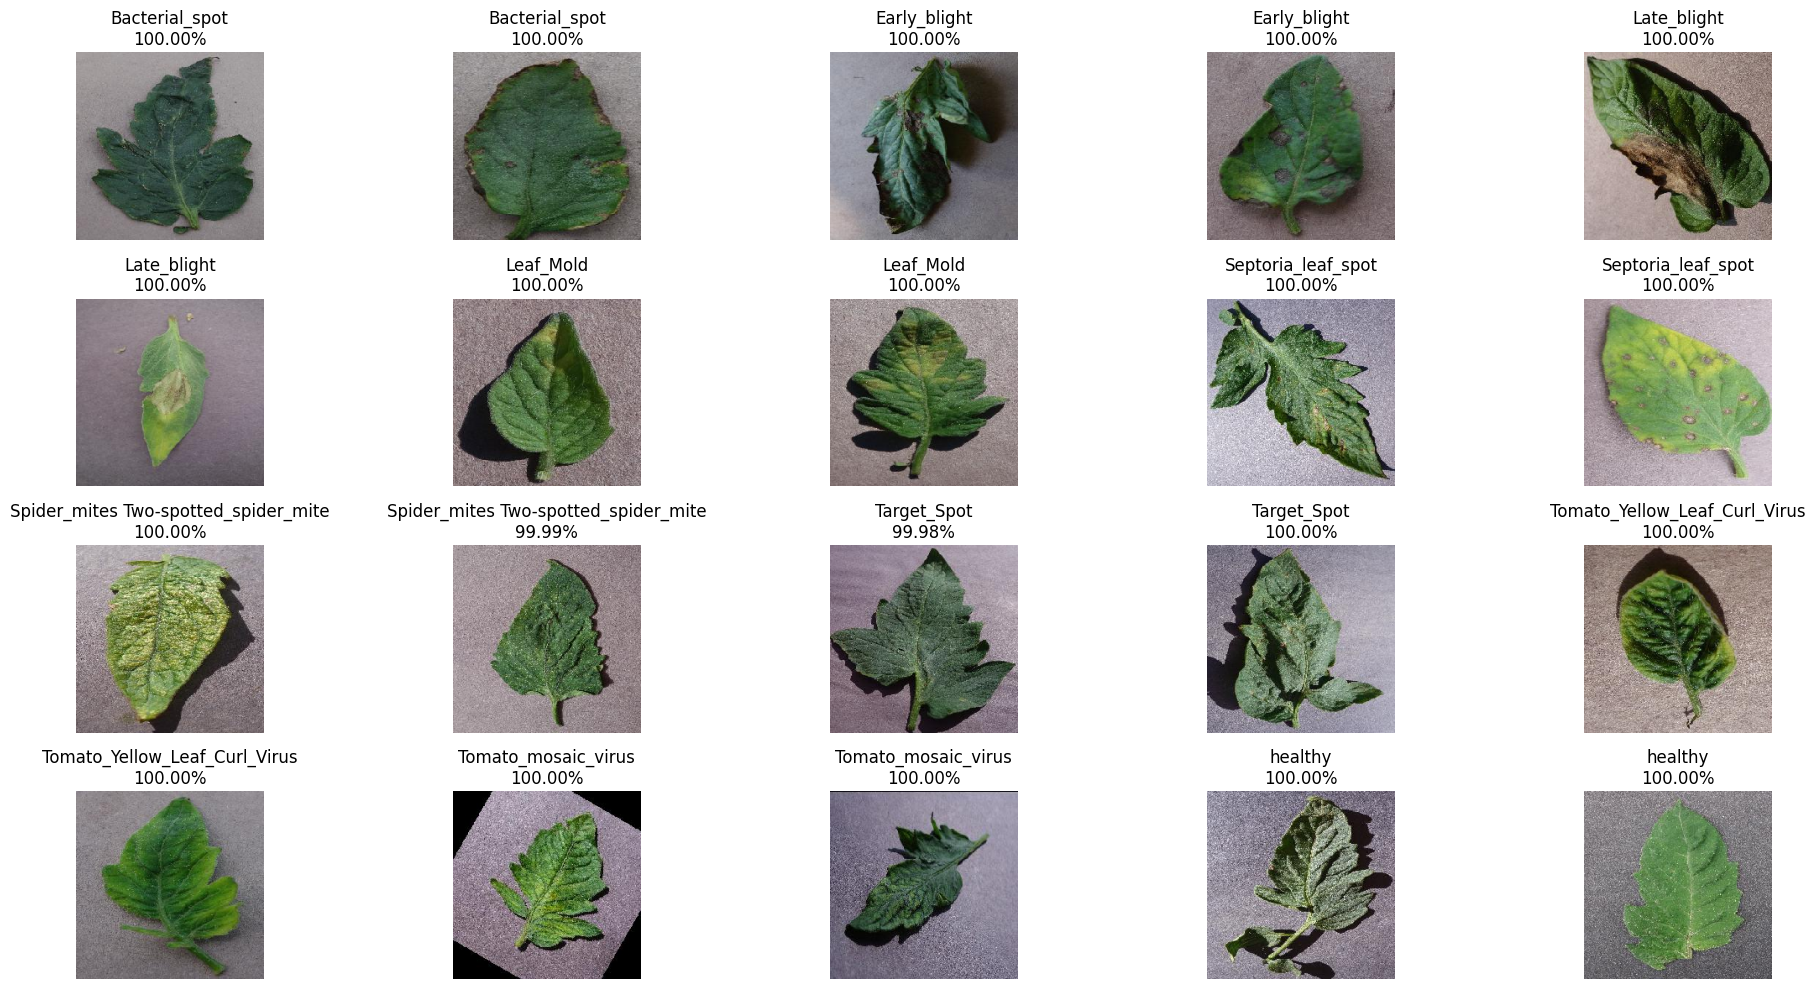

In [ ]:
# Seçilen fotoğrafların tahminlerini yap ve görselleştir
predict_and_display_images(model, get_random_images_from_class(train_dir,class_names), class_names)

1/1 [==============================] - 0s 28ms/step


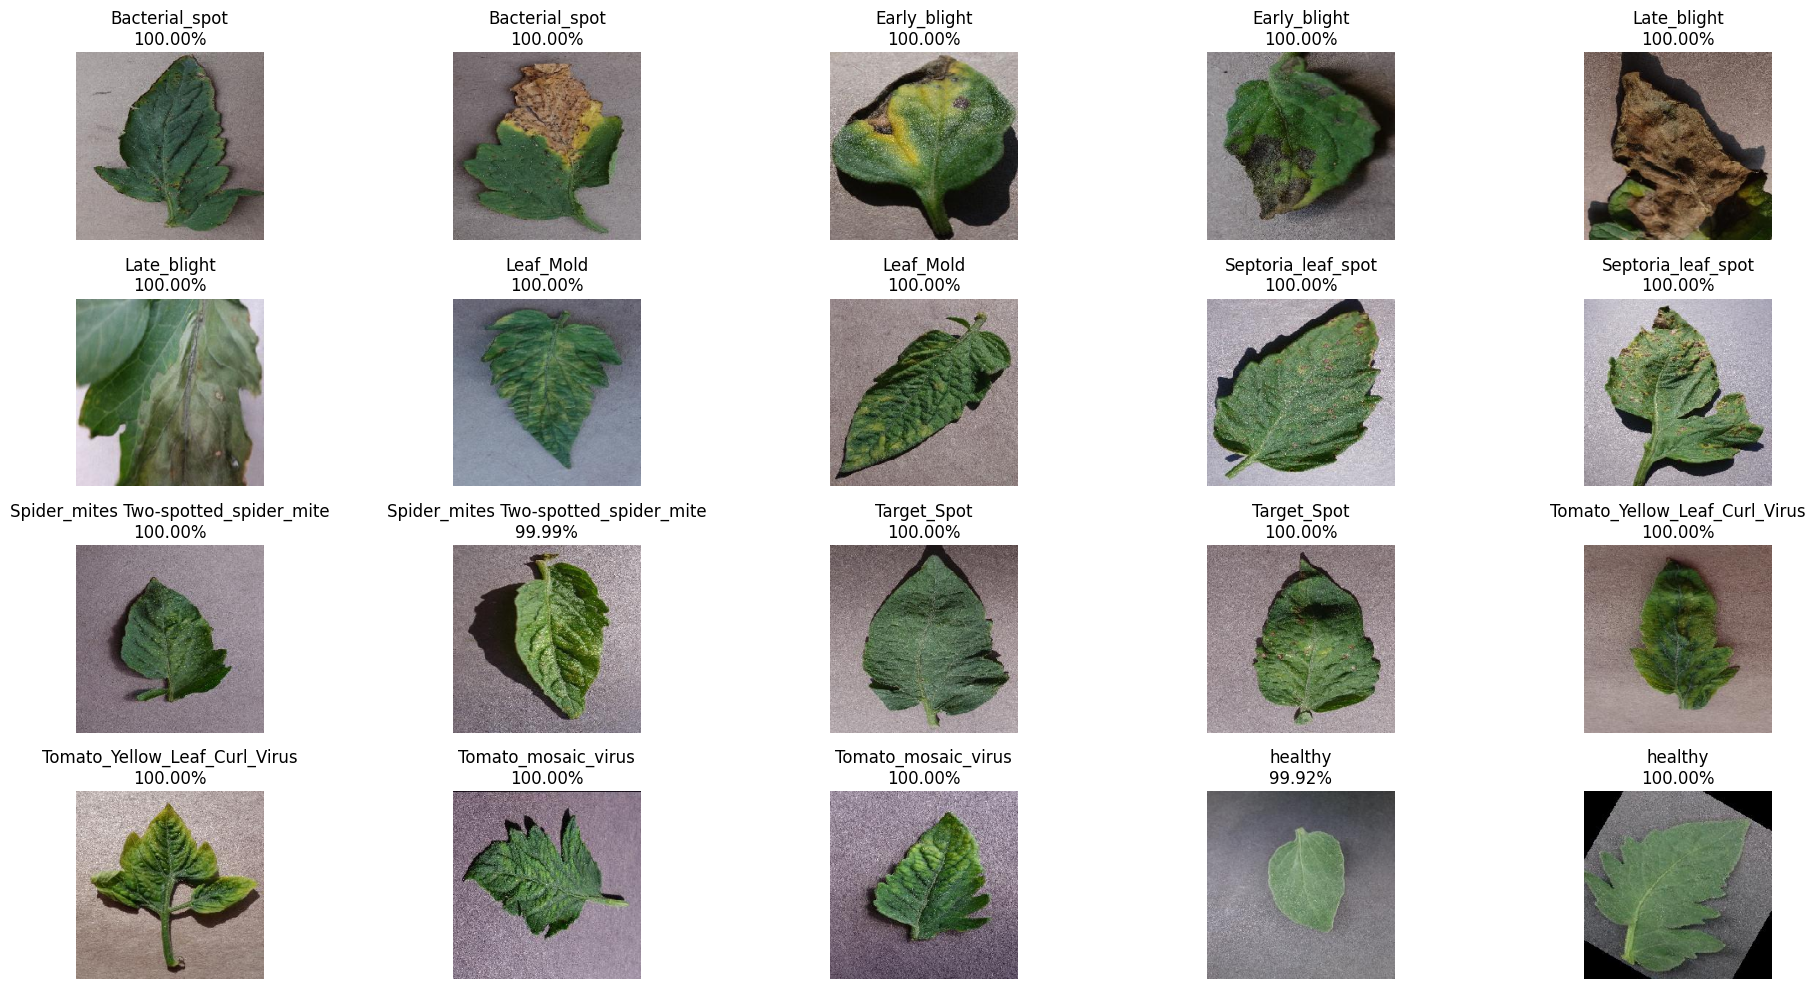

In [ ]:
# Valid klasörü için
valid_dir = '/content/drive/MyDrive/tomatoNewDataset/valid'

# Valid klasöründen rastgele fotoğraflar seç
valid_images = get_random_images_from_class(valid_dir, class_names)

# Seçilen fotoğrafların tahminlerini yap ve görselleştir
predict_and_display_images(model, valid_images, class_names)

# NASNetLarge


https://hilalgozutok.medium.com/evri%C5%9Fimli-sinir-a%C4%9Flar%C4%B1-convolutional-neural-networks-cnn-e61470e9bdb1


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import os
import random


In [ ]:
# Train Generator için batch size'ı küçültme
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(600, 600),
    batch_size=16,  # Batch boyutunu küçülttüm
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(600, 600),
    batch_size=16,  # Batch boyutunu küçülttüm
    class_mode='categorical')


Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# EfficientNetB0 modelini yükleyin
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(600, 600, 3))

# Global Average Pooling Layer ekleme
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Tam bağlantı katmanı ekleme
x = Dense(1024, activation='relu')(x)

# Çıkış katmanı ekleme
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Modeli birleştirme
model = Model(inputs=base_model.input, outputs=predictions)

# Modeli eğitim için derleme
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
model_save = tf.keras.callbacks.ModelCheckpoint('/path/to/save_directory/efficientnetb0_model.keras',
                                                save_best_only=True,
                                                monitor='val_loss',
                                                mode='min', verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
                                              patience=10, mode='min', verbose=1,
                                              restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                                                 patience=2, min_delta=0.001,
                                                 mode='min', verbose=1)

# Modeli eğitme
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[model_save, early_stop, reduce_lr],
    verbose=1)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7432 - loss: 0.7540
Epoch 1: val_loss improved from inf to 0.64446, saving model to /path/to/save_directory/efficientnetb0_model.keras
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 2307s 1s/step - accuracy: 0.7432 - loss: 0.7539 - val_accuracy: 0.8317 - val_loss: 0.6445 - learning_rate: 0.0010
Epoch 2/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8920 - loss: 0.3180
Epoch 2: val_loss improved from 0.64446 to 0.35141, saving model to /path/to/save_directory/efficientnetb0_model.keras
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 2127s 1s/step - accuracy: 0.8920 - loss: 0.3180 - val_accuracy: 0.8848 - val_loss: 0.3514 - learning_rate: 0.0010
Epoch 3/20
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9191 - loss: 0.2417
Epoch 3: val_loss improved from 0.35141 to 0.26531, saving model to /path/to/save_directory/efficientnetb0_model.keras
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 2130s 1s/step 